In [1]:
import os
import glob
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import plotly.express as px
from pointnet_loader import get_dataset, get_pretrained_model, get_class_map

## Load ModelNet10 dataset and pre-trained PointNet model

In [2]:
class_map = get_class_map() # dict, index -> class label
train_data, test_data = get_dataset()
pointnet_model = get_pretrained_model()

2022-03-29 15:47:59.640712: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-03-29 15:47:59.640733: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: snowy
2022-03-29 15:47:59.640737: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: snowy
2022-03-29 15:47:59.640798: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-03-29 15:47:59.640812: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-03-29 15:47:59.640815: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-03-29 15:47:59.640963: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical opera

## Get a incorrect predicitons

In [3]:
# Get where pointnet made the wrong predictions
objs = []
predictions = []
true_labels = []
total = 0
for points, labels in test_data:
    preds = pointnet_model.predict(points)
    preds = tf.math.argmax(preds,-1)
    for idx, pred in enumerate(preds):
        total += 1
        if pred.numpy() != labels.numpy()[idx]:
            objs.append(points[idx].numpy())
            predictions.append(pred.numpy())
            true_labels.append(labels[idx].numpy())

In [4]:
print("Accuracy: {:.2f}%".format((1- (len(objs)/total)) * 100))

Accuracy: 80.29%


In [7]:
def visualize_point_cloud(obj, color=None):
    obj_t = list(map(list, zip(*obj)))
    fig = px.scatter_3d(x=obj_t[0], y=obj_t[1], z=obj_t[2], color=color)
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

True Label: bathtub
Preicted: sofa


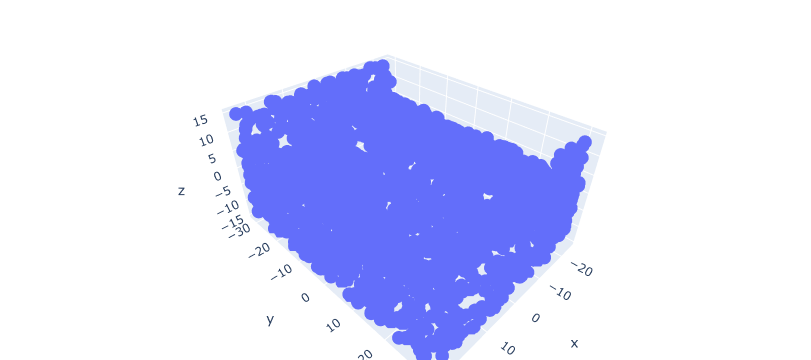

In [33]:
idx = 12
obj = objs[idx]
label = true_labels[idx]
prediction = predictions[idx]


# Visualize the actual cloud points
print("True Label: " + class_map[label])
print("Preicted: " + class_map[prediction])
visualize_point_cloud(obj)

## Get masks and masked object

In [34]:
# Create array of 1's and 0's to hide partial object. Since point cloud data is order invariant, we 
#   will hide points by "merging" them with unmasked points.

n_features = len(obj)
ratio_unmasked = 0.5
mask_bin = np.array([1 if random.uniform(0, 1) <= ratio_unmasked else 0 for x in range(n_features)])

In [35]:
import copy
def get_masked_object(obj, mask_bin):
    temp = copy.deepcopy(obj)
    indices = np.where(mask_bin == 1)
    vals = np.resize(temp[indices], obj.shape)
    return vals
vals = get_masked_object(obj, mask_bin)

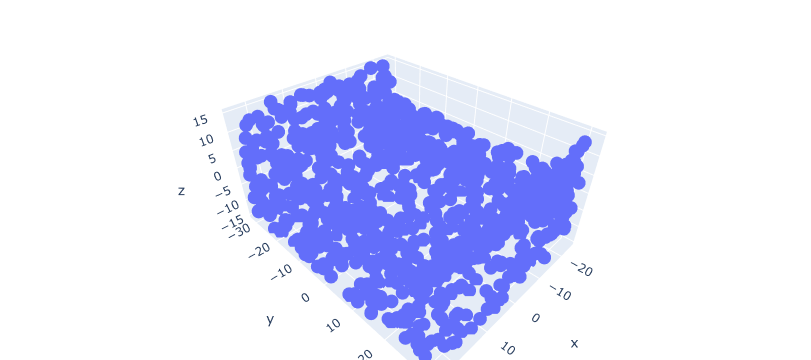

In [36]:
visualize_point_cloud(vals)

## Get probability for the class we are interested in

In [37]:
class_map

{0: 'night_stand',
 1: 'toilet',
 2: 'monitor',
 3: 'sofa',
 4: 'table',
 5: 'dresser',
 6: 'bathtub',
 7: 'desk',
 8: 'bed',
 9: 'chair'}

In [39]:
# Let's use predicted probability for each index
def get_idx_prob_pred(index, masked_obj, model):
    preds =  model.predict(np.array([masked_obj]))
    prob = preds[0][index]
    return prob, preds
prob, preds = get_idx_prob_pred(2, vals, pointnet_model)
print("label: " + class_map[tf.math.argmax(preds,-1).numpy()[0]])

label: bed


## MCMC mask selection

In [40]:
def get_new_step(mask_bin, num_samples=300):
    sample_idx = random.sample(range(len(mask_bin)), num_samples)
    new_mask_bin = mask_bin.copy()
    for idx in sample_idx:
        new_mask_bin[idx] = (mask_bin[idx] + 1) %  2
    return new_mask_bin

In [41]:
get_new_step(mask_bin)

array([1, 1, 0, ..., 1, 0, 0])

## MCMC algorithm

In [42]:
from tqdm import tqdm
def MCMC(total_iters, burn_in_iters, step_len, index_of_interest, obj, model):
    # Start at a random mask.
    n_features = len(obj)
    num_accept = 0
    
    mask_bin = np.array([random.randint(0, 1) for x in range(n_features)])
    masked_obj = get_masked_object(obj, mask_bin)
    prob, preds = get_idx_prob_pred(index_of_interest, masked_obj, model)
    labels = []
    masks = []
    probs = []
    
    for i in tqdm(range(total_iters)):
        new_mask_bin = get_new_step(mask_bin, num_samples=step_len)
        new_masked_obj = get_masked_object(obj, new_mask_bin)
        new_prob, new_preds = get_idx_prob_pred(index_of_interest, new_masked_obj, model)
        
        if random.uniform(0, 1) < new_prob/prob:
            mask_bin = new_mask_bin
            masked_obj = new_masked_obj
            prob = new_prob
            preds = new_preds
            num_accept += 1
        
        if i >= burn_in_iters:
            masks.append(mask_bin)
            probs.append(prob)
            labels.append(preds[0])
            
    print("Acceptance rate: " + str(num_accept/total_iters))
    
    return masks, probs, labels

In [44]:
masks, probs, labels = MCMC(total_iters=1000, burn_in_iters=100, step_len=1000, index_of_interest=3,
                           obj=obj, model=pointnet_model)

100%|███████████████████████████████████| 1000/1000 [00:23<00:00, 42.52it/s]

Acceptance rate: 0.878


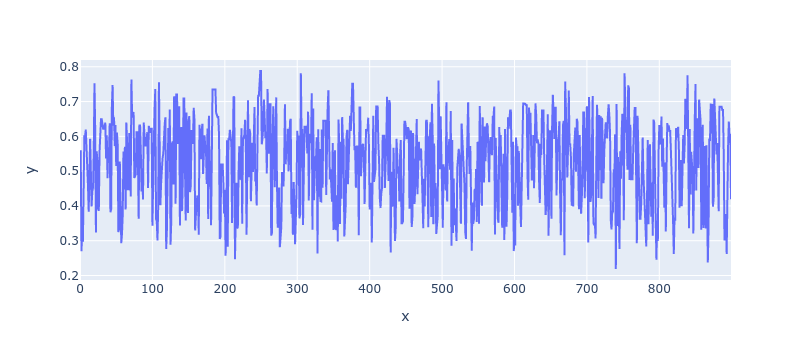

In [45]:
px.line(x=range(len(probs)), y = probs)

## MCMC point sample rate as importance

In [46]:
masks_transposed = np.array([list(x) for x in zip(*masks)])
sample_rates = [sum(x) / len(x) for x in masks_transposed]

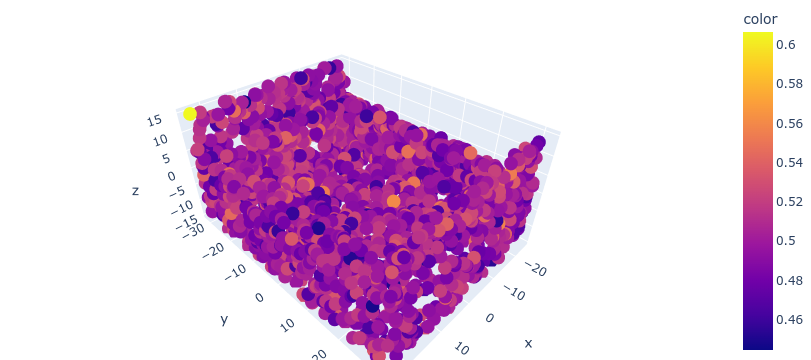

In [47]:
visualize_point_cloud(obj, color=sample_rates)